#### HQ-SAM (from train.py)

In [ ]:
# import 
import os
import argparse
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import random
from typing import Dict, List, Tuple

from segment_anything_training import sam_model_registry
from segment_anything_training.modeling import TwoWayTransformer, MaskDecoder

from utils.dataloader import get_im_gt_name_dict, create_dataloaders, RandomHFlip, Resize, LargeScaleJitter
from utils.loss_mask import loss_masks
import utils.misc as misc

#### LayerNorm2d
Z-Score Normalization = Standardization(표준화)

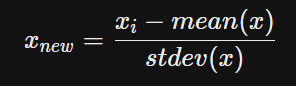

In [ ]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True) # 분산 계산
        x = (x - u) / torch.sqrt(s + self.eps) # Z-Score Normalization = Standardization(표준화)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x

#### MLP (Multilayer Perceptron)

In [ ]:
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        sigmoid_output: bool = False,
    ) -> None:
        super().__init__()
        self.num_layers = num_layers # mlp layer 수 지정
        h = [hidden_dim] * (num_layers - 1) # hidden layer의 dimension 지정
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim])
        )
        self.sigmoid_output = sigmoid_output # output에 sig 유무 지정

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x) # for문을 반복하며 layer 위치에 맞게 relu 적용
        if self.sigmoid_output: # sigmoid_output이 true일 경우 sigmoid 적용
            x = F.sigmoid(x)
        return x

#### *(중요 부분) MaskDecoderHQ

In [ ]:
class MaskDecoderHQ(MaskDecoder):
    def __init__(self, model_type):
        super().__init__(transformer_dim=256,
                        # TwoWayTransformer의 경우 
                        transformer=TwoWayTransformer(
                                depth=2,
                                embedding_dim=256,
                                mlp_dim=2048,
                                num_heads=8,
                            ),
                        num_multimask_outputs=3,
                        activation=nn.GELU,
                        iou_head_depth= 3,
                        iou_head_hidden_dim= 256,)
        assert model_type in ["vit_b", "vit_l", "vit_h"]

        # pretrain 된 vit weight 파일
        checkpoint_dict = {"vit_b":"pretrained_checkpoint/sam_vit_b_maskdecoder.pth",
                           "vit_l":"pretrained_checkpoint/sam_vit_l_maskdecoder.pth",
                           'vit_h':"pretrained_checkpoint/sam_vit_h_maskdecoder.pth"}
        checkpoint_path = checkpoint_dict[model_type]
        self.load_state_dict(torch.load(checkpoint_path))
        print("HQ Decoder init from SAM MaskDecoder")
        
        # parameter 업데이트를 막음
        for n,p in self.named_parameters():
            p.requires_grad = False

        transformer_dim=256
        vit_dim_dict = {"vit_b":768,"vit_l":1024,"vit_h":1280}
        # 지정한 모델 타입에 따라 dimention 조절
        vit_dim = vit_dim_dict[model_type]
        
        # HQ_token 생성 
        self.hf_token = nn.Embedding(1, transformer_dim)
        self.hf_mlp = MLP(transformer_dim, transformer_dim, transformer_dim // 8, 3)
        self.num_mask_tokens = self.num_mask_tokens + 1
        
        # ViT로 출력된 feature map을 ConvTranspose2d를 사용하여 upscaling (channel을 줄이고 size를 늘림)
        self.compress_vit_feat = nn.Sequential(
                                        nn.ConvTranspose2d(vit_dim, transformer_dim, kernel_size=2, stride=2),
                                        LayerNorm2d(transformer_dim),
                                        nn.GELU(), 
                                        nn.ConvTranspose2d(transformer_dim, transformer_dim // 8, kernel_size=2, stride=2))
        
        self.embedding_encoder = nn.Sequential(
                                        nn.ConvTranspose2d(transformer_dim, transformer_dim // 4, kernel_size=2, stride=2),
                                        LayerNorm2d(transformer_dim // 4),
                                        nn.GELU(),
                                        nn.ConvTranspose2d(transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2),
                                    )

        self.embedding_maskfeature = nn.Sequential(
                                        nn.Conv2d(transformer_dim // 8, transformer_dim // 4, 3, 1, 1), 
                                        LayerNorm2d(transformer_dim // 4),
                                        nn.GELU(),
                                        nn.Conv2d(transformer_dim // 4, transformer_dim // 8, 3, 1, 1))
        
    def forward(
    self,
    image_embeddings: torch.Tensor,
    image_pe: torch.Tensor,
    sparse_prompt_embeddings: torch.Tensor,
    dense_prompt_embeddings: torch.Tensor,
    multimask_output: bool,
    hq_token_only: bool,
    interm_embeddings: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict masks given image and prompt embeddings.

        Arguments:
          image_embeddings (torch.Tensor): the embeddings from the ViT image encoder
          image_pe (torch.Tensor): positional encoding with the shape of image_embeddings
          sparse_prompt_embeddings (torch.Tensor): the embeddings of the points and boxes
          dense_prompt_embeddings (torch.Tensor): the embeddings of the mask inputs
          multimask_output (bool): Whether to return multiple masks or a single
            mask.

        Returns:
          torch.Tensor: batched predicted hq masks
        """
        
        #conv에 넣기 위해 (B, C, H, W) 형태로 변경
        vit_features = interm_embeddings[0].permute(0, 3, 1, 2) # early-layer ViT feature, after 1st global attention block in ViT
        # ViT Feat (Global-local Fusion)
        hq_features = self.embedding_encoder(image_embeddings) + self.compress_vit_feat(vit_features)

        # 각 배치별 Mask & iou 생성
        batch_len = len(image_embeddings)
        masks = []
        iou_preds = []
        for i_batch in range(batch_len):
            mask, iou_pred = self.predict_masks(
                image_embeddings=image_embeddings[i_batch].unsqueeze(0),
                image_pe=image_pe[i_batch],
                #sparse_prompt_embeddings: the embeddings of the points and boxes
                sparse_prompt_embeddings=sparse_prompt_embeddings[i_batch],
                dense_prompt_embeddings=dense_prompt_embeddings[i_batch],
                hq_feature = hq_features[i_batch].unsqueeze(0)
            )
            masks.append(mask)
            iou_preds.append(iou_pred)
        masks = torch.cat(masks,0)
        iou_preds = torch.cat(iou_preds,0)

        # Select the correct mask or masks for output
        if multimask_output:
            # mask with highest score (slice를 이용하여 list 추출 범위 지정)
            mask_slice = slice(1,self.num_mask_tokens-1)
            iou_preds = iou_preds[:, mask_slice]
            iou_preds, max_iou_idx = torch.max(iou_preds,dim=1)
            iou_preds = iou_preds.unsqueeze(1)
            masks_multi = masks[:, mask_slice, :, :]
            masks_sam = masks_multi[torch.arange(masks_multi.size(0)),max_iou_idx].unsqueeze(1)
        else:
            # masks의 첫번째 값 추출
            mask_slice = slice(0, 1)
            masks_sam = masks[:,mask_slice]

        masks_hq = masks[:,slice(self.num_mask_tokens-1, self.num_mask_tokens), :, :]
        
        if hq_token_only:
            return masks_hq
        else:
            return masks_sam, masks_hq
    
    def predict_masks(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
        hq_feature: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
          Arguments:
          image_embeddings (torch.Tensor): the embeddings from the ViT image encoder
          image_pe (torch.Tensor): positional encoding with the shape of image_embeddings
          sparse_prompt_embeddings (torch.Tensor): the embeddings of the points and boxes
          dense_prompt_embeddings (torch.Tensor): the embeddings of the mask inputs
        """

        output_tokens = torch.cat([self.iou_token.weight, self.mask_tokens.weight, self.hf_token.weight], dim=0)
        output_tokens = output_tokens.unsqueeze(0).expand(sparse_prompt_embeddings.size(0), -1, -1)
        tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)

        # Expand per-image data in batch direction to be per-mask
        src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0) # torch.repeat_interleave(input, repeat, dim) 반복 횟수만큼 텐서 반복
        src = src + dense_prompt_embeddings # image imbedding + embeddings of the mask inputs
        pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)
        b, c, h, w = src.shape

        # Run the transformer
        hs, src = self.transformer(src, pos_src, tokens)
        iou_token_out = hs[:, 0, :]
        mask_tokens_out = hs[:, 1 : (1 + self.num_mask_tokens), :]

        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w)

        upscaled_embedding_sam = self.output_upscaling(src)
        upscaled_embedding_ours = self.embedding_maskfeature(upscaled_embedding_sam) + hq_feature
        
        hyper_in_list: List[torch.Tensor] = []
        for i in range(self.num_mask_tokens):
            if i < 4:
                hyper_in_list.append(self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
            else:
                hyper_in_list.append(self.hf_mlp(mask_tokens_out[:, i, :]))

        hyper_in = torch.stack(hyper_in_list, dim=1)
        b, c, h, w = upscaled_embedding_sam.shape

        masks_sam = (hyper_in[:,:4] @ upscaled_embedding_sam.view(b, c, h * w)).view(b, -1, h, w)
        masks_ours = (hyper_in[:,4:] @ upscaled_embedding_ours.view(b, c, h * w)).view(b, -1, h, w)
        masks = torch.cat([masks_sam,masks_ours],dim=1)
        
        iou_pred = self.iou_prediction_head(iou_token_out)

        return masks, iou_pred

[2, 3]